# Set up environment

In [13]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import collections
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Data pre-processing

In [2]:
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if len(X.shape) > 1: # this is to extract the mono chanel if input file is in stereo format
            X = X.mean(axis=1)
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [3]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
observed_emotions=['sad', 'neutral', 'fearful']


In [8]:
# encode and decode the emotions into binary format
emotionsEncode={
  'fearful': 1,
  'sad': 1,
  'neutral': 0,
  'happy':0
}

emotionsToLables={
  0: 'non-negative',
    1: 'negative'
}

In [4]:
# functions to encode label to numeric
def emotion_encode(y_train):
    res = []
    for y_t in y_train:
        res.append(emotionsEncode[y_t])
    return res

# functions to decode numeric to label 
def emotion_decode(y_pred):
    res = []
    for y_t in y_pred:
        res.append(emotionsToLables[y_t])
    return res

In [5]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("C:\\Users\\yinxiao\\Downloads\\offline_samples\\Audio_*_Actors_01-24\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    for file in glob.glob("C:\\Users\\yinxiao\\Downloads\\offline_samples\\realsamples\\sad\\*.wav"): # add additional real-life conversation samples
        emotion = 'sad'
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    for file in glob.glob("C:\\Users\\yinxiao\\Downloads\\offline_samples\\realsamples\\happy\\*.wav"): # add additional real-life conversation samples
        emotion = 'happy'
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Load the dataset

In [6]:
x_train,x_test,y_train,y_test=load_data(test_size=0.1) # this will reserve 10% of dataset as test dataset

### encode the emotions from label to numeric

In [9]:
# encode the 
y_train1 = emotion_encode(y_train)
y_test1 = emotion_encode(y_test)

In [11]:
# check the class distribution
collections.Counter(y_train1)

Counter({1: 677, 0: 176})

### Oversample the minority class via SMOTE
See more details here: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [15]:
oversample = SMOTE()
x_train2, y_train2 = oversample.fit_resample(x_train, y_train1)
# summarize the new class distribution
collections.Counter(y_train2)

Counter({1: 677, 0: 677})

# Train the model

In [16]:
model=MLPClassifier()

In [17]:
model.fit(x_train2,y_train2)

MLPClassifier()

# Test the model

In [18]:
y_pred=model.predict(x_test)

In [19]:
accuracy=accuracy_score(y_true=y_test1, y_pred=y_pred)
#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 89.47%


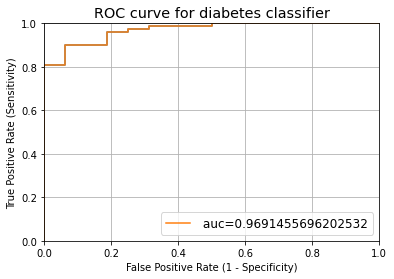

In [20]:
# get the ROC curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score

y_pred_proba = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test1, y_pred_proba)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
auc = metrics.roc_auc_score(y_test1, y_pred_proba)
plt.plot(fpr,tpr,label=" auc="+str(auc))
plt.legend(loc=4)

In [21]:
# test with some real-life conversation
res =[]
for file in glob.glob("C:\\Users\\yinxiao\\Downloads\\offline_samples\\realsamples\\sad\\*.wav"):
    res.append(emotionsToLables[model.predict(np.array([extract_feature(file, mfcc=True, chroma=True, mel=True)]))[0]])
res

['negative', 'negative', 'negative', 'negative']

# Output the model file

In [ ]:
pickle.dump(model, open("mlp_classifier1.model", "wb"))